#  <font color='#FFE15D'><b> Language Modeling </b></font>


# 🔴 **Environment Setup**

## 🟠 Install Requirements

In [ ]:
!pip install -q portalocker>=2.0.0

In [ ]:
!pip install -q torch==2.2.2 \
            torchvision==0.17.2 \
            torchaudio==2.2.2 \
            torchtext==0.17.2 \
            torchmetrics==1.3.1 \
            torchdata==0.7.1 \
            numpy==1.26.4 \
            tqdm==4.67.1


In [ ]:
!pip uninstall torchtune

# 🔴 **Import Libs**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

from collections import Counter

In [ ]:
!python --version

Python 3.11.13


In [ ]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.2.2+cu121
torchtext --> 0.17.2+cpu
tqdm --> 4.67.1


# 🔴 **Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 Load the Dataset

🔰 In this session you should load WikiText2 dataset.

In [ ]:
#train_iter, valid_iter, test_iter = WikiText2('/content/')

In [ ]:
!unzip '/content/drive/MyDrive/Datasets/wikitext-2-v1.zip' -d '/content/'

Archive:  /content/drive/MyDrive/Datasets/wikitext-2-v1.zip
   creating: /content/wikitext-2/
  inflating: /content/wikitext-2/wiki.test.tokens  
  inflating: /content/wikitext-2/wiki.valid.tokens  
  inflating: /content/wikitext-2/wiki.train.tokens  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_data_iterators(base_path):
    import os
    def read_file_gen(filename):
        filepath = os.path.join(base_path, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            yield from (line.strip() for line in f if line.strip() and not line.startswith('='))

    train_iter = read_file_gen('wiki.train.tokens')
    valid_iter = read_file_gen('wiki.valid.tokens')
    test_iter  = read_file_gen('wiki.test.tokens')

    return train_iter, valid_iter, test_iter


In [ ]:
base_path = '/content/wikitext-2'
train_iter, valid_iter, test_iter = load_data_iterators(base_path)

In [ ]:
train_iter

ShardingFilterIterDataPipe

## 🟠 Build vocabulary and save it

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [ ]:
train_iter, valid_iter, test_iter = load_data_iterators(base_path)

In [ ]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
vocab.get_stoi()

{'攻殻機動隊': 28781,
 '戦場のヴァルキュリア3': 28780,
 'წ': 28776,
 'ც': 28774,
 'ზ': 28770,
 'გ': 28768,
 '์': 28767,
 'ง': 28765,
 'กัลยาณมิตร': 28764,
 'γ': 28761,
 'łaszcz': 28759,
 'ürümqi': 28757,
 'último': 28756,
 'ø': 28754,
 'ösel': 28753,
 'être': 28752,
 'élodie': 28749,
 'álvaro': 28748,
 '§': 28747,
 'zuzanna': 28745,
 'zuniga': 28744,
 'zoromski': 28742,
 'zongwang': 28741,
 'zhu': 28737,
 'zhishen': 28736,
 'zhejiang': 28735,
 'zhao': 28734,
 'zatanna': 28728,
 'yvonne': 28720,
 'yurikago': 28719,
 'yukizuki': 28717,
 'ysabel': 28713,
 'youngsters': 28711,
 'yorkers': 28710,
 'yiddish': 28705,
 'yesterday': 28704,
 'yeoh': 28703,
 'yen': 28702,
 'yellowwoods': 28701,
 'yarder': 28698,
 'yammer': 28696,
 'yamamoto': 28695,
 'xlvii': 28694,
 'xfx': 28692,
 'xamar': 28691,
 'wumpa': 28686,
 'wsmv': 28685,
 'wrists': 28684,
 'wrapping': 28683,
 'worshippers': 28681,
 'worshiping': 28680,
 'worrisome': 28679,
 'workload': 28678,
 'workhouse': 28677,
 'worf': 28676,
 'woodcut': 28673,
 'wo

In [ ]:
torch.save(vocab, '/content/drive/MyDrive/Datasets/vocab.pt')
torch.save(vocab, 'vocab.pt')

## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

### 🟡 Analyze the most common and least common words in the dataset.

In [ ]:
freqs = Counter()
for tokens in map(tokenizer, train_iter):
  freqs.update(tokens)

In [ ]:
freqs.most_common()[-6000:]

[('refreshing', 4),
 ('aback', 4),
 ('uproar', 4),
 ('novi', 4),
 ('mshd', 4),
 ('881', 4),
 ('ibrahima', 4),
 ('1726', 4),
 ('mandé', 4),
 ('yalunka', 4),
 ('bundu', 4),
 ('almami', 4),
 ('donnel', 4),
 ('cctv', 4),
 ('fiancée', 4),
 ('fibres', 4),
 ('calmly', 4),
 ('gaviria', 4),
 ('andes', 4),
 ('stylized', 4),
 ('40th', 4),
 ('zurich', 4),
 ('rafa', 4),
 ('jonas', 4),
 ('mcenroe', 4),
 ('tiebreaker', 4),
 ('borg', 4),
 ('racquets', 4),
 ('battled', 4),
 ('tiebreak', 4),
 ('surpass', 4),
 ('prolonging', 4),
 ('baseline', 4),
 ('forehand', 4),
 ('dogfights', 4),
 ('simulators', 4),
 ('graphical', 4),
 ('hantzopoulos', 4),
 ('gauges', 4),
 ('itcz', 4),
 ('accelerating', 4),
 ('mudskippers', 4),
 ('tasting', 4),
 ('bbdo', 4),
 ('squirrels', 4),
 ('mustang', 4),
 ('overlapped', 4),
 ('stella', 4),
 ('mulhall', 4),
 ('windass', 4),
 ('oblivion', 4),
 ('californicus', 4),
 ('diets', 4),
 ('rabbits', 4),
 ('mites', 4),
 ('hares', 4),
 ('sonora', 4),
 ('wheatgrass', 4),
 ('coyote', 4),
 ('l

### 🟡  Please proceed with further exploration of the dataset. what do you suggest?

## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [ ]:
train_iter, valid_iter, test_iter = load_data_iterators(base_path)

In [ ]:
data = torch.cat([torch.LongTensor(vocab(tokenizer(line))) for line in train_iter])

seq_len = 120
M = len(data) // seq_len

r = len(data) % seq_len
data = torch.cat((data, torch.LongTensor([0]))) if r==0 else data

inputs = data[:M*seq_len]
inputs = inputs.reshape(-1, seq_len)

targets = data[1:M*seq_len+1]
targets = targets.reshape(-1, seq_len)

inputs.shape, targets.shape

(torch.Size([17083, 120]), torch.Size([17083, 120]))

In [ ]:
def data_process(raw_text_iter, seq_len):
  data = torch.cat([torch.LongTensor(vocab(tokenizer(line))) for line in raw_text_iter])

  M = len(data) // seq_len

  r = len(data) % seq_len
  data = torch.cat((data, torch.LongTensor([0]))) if r==0 else data

  inputs = data[:M*seq_len]
  inputs = inputs.reshape(-1, seq_len)

  targets = data[1:M*seq_len+1]
  targets = targets.reshape(-1, seq_len)

  return inputs, targets

In [ ]:
del data, inputs, targets

In [ ]:
inputs, targets = data_process(train_iter, seq_len=65)
inputs.shape, targets.shape

(torch.Size([31538, 65]), torch.Size([31538, 65]))

In [ ]:
seq_len = 35

X_train, y_train = data_process(train_iter, seq_len)
X_valid, y_valid = data_process(valid_iter, seq_len)
X_test, y_test = data_process(test_iter, seq_len)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([58571, 35]),
 torch.Size([58571, 35]),
 torch.Size([6126, 35]),
 torch.Size([6126, 35]),
 torch.Size([6910, 35]),
 torch.Size([6910, 35]))

## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [ ]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

In [ ]:
train_set = LanguageModelDataset(X_train, y_train)
valid_set = LanguageModelDataset(X_valid, y_valid)
test_set = LanguageModelDataset(X_test, y_test)

In [ ]:
train_set[0]

(tensor([    9,  3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,
          3869,    21,   780, 28780,     2,  6182,     3,  3849,     4,     1,
          5023,    88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,
           881,   629,   976,     2,    23]),
 tensor([ 3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,  3869,
            21,   780, 28780,     2,  6182,     3,  3849,     4,     1,  5023,
            88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,   881,
           629,   976,     2,    23,     8]))

## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [ ]:
batch_size = 20

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([20, 35]), torch.Size([20, 35]))

# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [ ]:
class LanguageModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
                dropout_embd=0.5, dropout_rnn=0.5):
    super().__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    self.dropout = nn.Dropout(p=dropout_embd)

    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                        dropout=dropout_rnn, batch_first=True)

    self.fc = nn.Linear(hidden_dim, vocab_size)

  def forward(self, src):
    embedding = self.dropout(self.embedding(src))
    output, hidden = self.lstm(embedding)
    prediction = self.fc(output)
    return prediction

In [ ]:
model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=300,
                      hidden_dim=512,
                      num_layers=2,
                      dropout_embd=0.65,
                      dropout_rnn=0.5)
model

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.65, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
model(x_batch).shape

torch.Size([20, 35, 28782])

In [ ]:
num_trainable_params(model.embedding), num_trainable_params(model.lstm), num_trainable_params(model.fc)

(8.6346, 3.76832, 14.765166)

# 🔴 **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 512
num_layers = 2
dropout_embd = 0.5
dropout_rnn = 0.2

model = LanguageModel(vocab_size, embedding_dim,
                      hidden_dim, num_layers,
                      dropout_embd, dropout_rnn).to(device)

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.5, weight_decay=0, momentum=0.9, nesterov=True)

loss_fn = nn.CrossEntropyLoss()

metric = tm.text.Perplexity().to(device)

In [ ]:
clip = 0.25

# 🔴 **Train**

🔰 This is the template for train function, change it if needed.

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      loss.backward()

      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=clip)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

print(loss)

tensor(10.2694, device='cuda:0')


In [ ]:
outputs.reshape(-1, outputs.shape[-1]).shape, targets.flatten().shape

(torch.Size([700, 28782]), torch.Size([700]))

In [ ]:
torch.cuda.empty_cache()

### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.9, momentum=0.9)

In [ ]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

Epoch 99: 100%|██████████| 50/50 [00:01<00:00, 26.71batch/s, loss=0.318, metric=1.37]


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs = 1

for lr in [2, 0.9, 0.5, 0.3, 0.09, 0.05]:
  print(f'LR={lr}')

  model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)
  model = torch.load('/content/model-ppl_147.pt')

  # optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0, momentum=0.9)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-6, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs = 1

for lr in [3.]:
  for wd in [1e-6, 1e-4, 1e-5]:
    print(f'LR={lr}, WD={wd}')

    model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

    for epoch in range(num_epochs):
      model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

LR=3.0, WD=1e-06


100%|██████████| 2929/2929 [01:51<00:00, 26.36batch/s, loss=5.89, metric=363]



LR=3.0, WD=0.0001


100%|██████████| 2929/2929 [01:50<00:00, 26.50batch/s, loss=6.26, metric=524]



LR=3.0, WD=1e-05


100%|██████████| 2929/2929 [01:50<00:00, 26.46batch/s, loss=5.93, metric=376]

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.5).to(device)

In [ ]:
model = torch.load('/content/model-ppl_133.pt')

In [ ]:
lr = 0.05
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 30

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████| 2929/2929 [01:52<00:00, 26.12batch/s, loss=7.15, metric=1.27e+3]


Model Saved!
Valid: Loss = 6.741, Metric = 846.0



Epoch 2: 100%|██████████| 2929/2929 [01:52<00:00, 26.09batch/s, loss=6.95, metric=1.04e+3]


Model Saved!
Valid: Loss = 6.711, Metric = 821.4



Epoch 3: 100%|██████████| 2929/2929 [01:52<00:00, 26.06batch/s, loss=6.84, metric=936]


Model Saved!
Valid: Loss = 6.504, Metric = 668.0



Epoch 4: 100%|██████████| 2929/2929 [01:52<00:00, 26.02batch/s, loss=6.63, metric=761]


Model Saved!
Valid: Loss = 6.342, Metric = 568.0



Epoch 5: 100%|██████████| 2929/2929 [01:52<00:00, 26.03batch/s, loss=6.51, metric=672]


Model Saved!
Valid: Loss = 6.239, Metric = 512.5



Epoch 6: 100%|██████████| 2929/2929 [01:52<00:00, 26.00batch/s, loss=6.42, metric=612]


Model Saved!
Valid: Loss = 6.147, Metric = 467.2



Epoch 7: 100%|██████████| 2929/2929 [01:52<00:00, 25.99batch/s, loss=6.34, metric=565]


Model Saved!
Valid: Loss = 6.086, Metric = 439.8



Epoch 8: 100%|██████████| 2929/2929 [01:52<00:00, 26.04batch/s, loss=6.27, metric=529]


Model Saved!
Valid: Loss = 6.017, Metric = 410.2



Epoch 9: 100%|██████████| 2929/2929 [01:52<00:00, 26.07batch/s, loss=6.21, metric=498]


Model Saved!
Valid: Loss = 5.967, Metric = 390.2



Epoch 10: 100%|██████████| 2929/2929 [01:52<00:00, 26.01batch/s, loss=6.15, metric=471]


Model Saved!
Valid: Loss = 5.91, Metric = 368.7



Epoch 11: 100%|██████████| 2929/2929 [01:53<00:00, 25.91batch/s, loss=6.1, metric=447]


Model Saved!
Valid: Loss = 5.882, Metric = 358.7



Epoch 12: 100%|██████████| 2929/2929 [01:52<00:00, 25.94batch/s, loss=6.05, metric=426]


Model Saved!
Valid: Loss = 5.825, Metric = 338.8



Epoch 13: 100%|██████████| 2929/2929 [01:52<00:00, 25.98batch/s, loss=6.01, metric=408]


Model Saved!
Valid: Loss = 5.789, Metric = 326.6



Epoch 14: 100%|██████████| 2929/2929 [01:52<00:00, 26.02batch/s, loss=5.97, metric=392]


Model Saved!
Valid: Loss = 5.748, Metric = 313.7



Epoch 15: 100%|██████████| 2929/2929 [01:53<00:00, 25.90batch/s, loss=5.93, metric=378]


Model Saved!
Valid: Loss = 5.719, Metric = 304.5



Epoch 16: 100%|██████████| 2929/2929 [01:53<00:00, 25.89batch/s, loss=5.9, metric=365]


Model Saved!
Valid: Loss = 5.694, Metric = 296.9



Epoch 17: 100%|██████████| 2929/2929 [01:52<00:00, 25.97batch/s, loss=5.87, metric=354]


Model Saved!
Valid: Loss = 5.673, Metric = 290.8



Epoch 18: 100%|██████████| 2929/2929 [01:52<00:00, 25.94batch/s, loss=5.84, metric=343]


Model Saved!
Valid: Loss = 5.643, Metric = 282.4



Epoch 19: 100%|██████████| 2929/2929 [01:52<00:00, 25.95batch/s, loss=5.81, metric=334]


Model Saved!
Valid: Loss = 5.62, Metric = 275.8



Epoch 20: 100%|██████████| 2929/2929 [01:52<00:00, 25.92batch/s, loss=5.78, metric=325]


Model Saved!
Valid: Loss = 5.602, Metric = 270.9



Epoch 21: 100%|██████████| 2929/2929 [01:52<00:00, 25.94batch/s, loss=5.76, metric=317]


Model Saved!
Valid: Loss = 5.58, Metric = 265.2



Epoch 22: 100%|██████████| 2929/2929 [01:52<00:00, 25.94batch/s, loss=5.73, metric=309]


Model Saved!
Valid: Loss = 5.563, Metric = 260.6



Epoch 23: 100%|██████████| 2929/2929 [01:52<00:00, 25.93batch/s, loss=5.71, metric=302]


Model Saved!
Valid: Loss = 5.551, Metric = 257.4



Epoch 24: 100%|██████████| 2929/2929 [01:53<00:00, 25.91batch/s, loss=5.69, metric=295]


Model Saved!
Valid: Loss = 5.532, Metric = 252.6



Epoch 25: 100%|██████████| 2929/2929 [01:53<00:00, 25.89batch/s, loss=5.67, metric=289]


Model Saved!
Valid: Loss = 5.507, Metric = 246.3



Epoch 26: 100%|██████████| 2929/2929 [01:53<00:00, 25.86batch/s, loss=5.65, metric=283]


Model Saved!
Valid: Loss = 5.502, Metric = 245.3



Epoch 27: 100%|██████████| 2929/2929 [01:53<00:00, 25.70batch/s, loss=5.63, metric=277]


Model Saved!
Valid: Loss = 5.478, Metric = 239.3



Epoch 28: 100%|██████████| 2929/2929 [01:53<00:00, 25.71batch/s, loss=5.61, metric=272]


Model Saved!
Valid: Loss = 5.471, Metric = 237.7



Epoch 29: 100%|██████████| 2929/2929 [01:53<00:00, 25.92batch/s, loss=5.59, metric=267]


Model Saved!
Valid: Loss = 5.459, Metric = 234.9



Epoch 30: 100%|██████████| 2929/2929 [01:53<00:00, 25.86batch/s, loss=5.57, metric=262]


Model Saved!
Valid: Loss = 5.443, Metric = 231.2



## 🟠 Main Loop

🔰 Define model.

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Plot

🔰 Plot learning curves

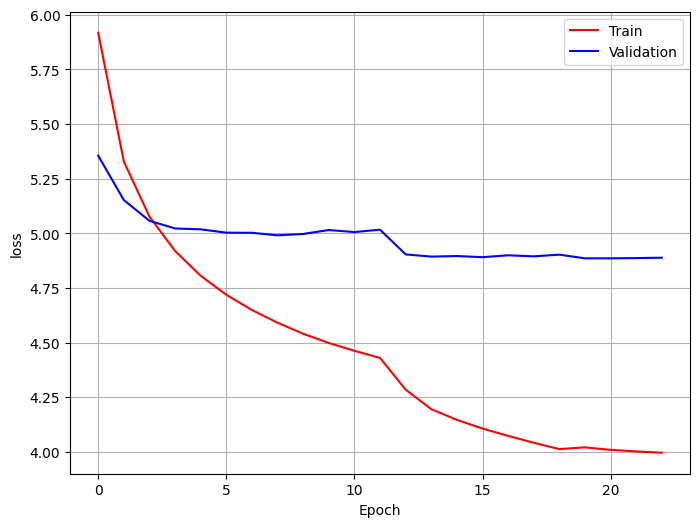

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set and images that are not present in the dataset.

In [ ]:
model_path = '/content/model.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
loss_valid, metric_valid = evaluate(model, valid_loader, loss_fn, metric)
metric_valid

231.17860412597656

In [ ]:
loss_test, metric_test = evaluate(model, test_loader, loss_fn, metric)
metric_test

216.9165802001953

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(28782, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=28782, bias=True)
)

In [ ]:
prompt = 'In a galaxy far, far away, there'

indices = vocab(tokenizer(prompt))
itos = vocab.get_itos()

max_seq_len = 35
for i in range(max_seq_len):
  src = torch.LongTensor(indices).to(device)

  with torch.no_grad():
    prediction = model(src)

  # Method 1
  # idx = torch.argmax(prediction[-1])
  # itos = vocab.get_itos()
  # itos[idx]

  # Method 2
  temperature = 0.5
  probs = torch.softmax(prediction[-1]/temperature, dim=0)

  idx = vocab['<ukn>']
  while idx == vocab['<ukn>']:
    idx = torch.multinomial(probs, num_samples=1).item()

  token = itos[idx]
  prompt += ' ' + token

  if idx == vocab['.']:
    break

  indices.append(idx)

print(prompt)

In a galaxy far, far away, there is a few @-@ distance @-@ than @-@ century , which is a range of the time .


In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
  if seed is not None:
    torch.manual_seed(seed)

  indices = vocab(tokenizer(prompt))
  itos = vocab.get_itos()

  for i in range(max_seq_len):
    src = torch.LongTensor(indices).to(device)

    with torch.no_grad():
      prediction = model(src)

    # Method 1
    # idx = torch.argmax(prediction[-1])
    # itos = vocab.get_itos()
    # itos[idx]

    # Method 2
    probs = torch.softmax(prediction[-1]/temperature, dim=0)

    idx = vocab['<ukn>']
    while idx == vocab['<ukn>']:
      idx = torch.multinomial(probs, num_samples=1).item()

    token = itos[idx]
    prompt += ' ' + token

    if idx == vocab['.']:
      return prompt

    indices.append(idx)

  return prompt

In [ ]:
prompt = 'In a galaxy far, far away, there'
prompt = 'The sun was setting in the'
prompt = 'Once upon a time, there lived a young princess named'
prompt = 'What is the meaning '

generate(prompt, 35, 0.5, model, tokenizer, vocab)

'What is the meaning  of the world .'